In [17]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dense, Input, Lambda, concatenate
from tensorflow.keras.optimizers import RMSprop, Adam

In [18]:
folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [19]:
# Read in files from folders, store as np arrays of images (X_train) and clinsig labels (y_train)
# clinsig TRUE = 1, FALSE = 0
X_clinsig = []
y_clinsig = []

X_indolent = []
y_indolent = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))    
        if adc_t2 == 'adc':
            if label == 'TRUE':
                X_clinsig.append(array)
                y_clinsig.append(1)
            else:
                X_indolent.append(array)
                y_indolent.append(0)

# Random over-sampling to remedy imbalanced dataset
print('Original: indolent={}, clinsig={}'.format(len(y_indolent), len(y_clinsig)))

Original: indolent=197, clinsig=59


In [20]:
# Generate imgaes of minority class (clinsig)
X = []
y = []
X.extend(X_indolent)
X.extend(X_clinsig)
y.extend(y_indolent)
y.extend(y_clinsig)

datagen = ImageDataGenerator(
#                     rescale=1./255,
                    shear_range=0.05,
#                     zoom_range=[,1],
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

X_clinsig = np.array(X_clinsig)
y_clinsig = np.array(y_clinsig)
np.asarray(y_clinsig).astype('float32').reshape((-1,1))

for img in X_clinsig:
    img = img.reshape((1,) + img.shape)
    for x, val in zip(datagen.flow(img, batch_size=1), range(2)):
        X.append(x[0])
        y.append(1)

X = np.array(X)
y = np.array(y)
print(Counter(y))
print(len(X), len(y))

Counter({0: 197, 1: 177})
374 374


In [21]:
X, y = shuffle(X, y)

# Now split this into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=280, nval=94


In [22]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
# conv_base.summary()

In [23]:
chanDim = 3

model = Sequential()
model.add(conv_base)

model.add(Conv2D(32, (3, 3), padding="same")) # kernel_initializer=init ? 
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

for i in range(9):
    model.add(Conv2D(32, (3, 3), padding="same")) 
    model.add(BatchNormalization(axis=chanDim))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    
model.add(AveragePooling2D(pool_size=(3, 3), padding="same"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Sigmoid function at the end because we have just two classes

# model.summary()

In [24]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-5), metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=Adam(lr=3e-4), metrics=['acc'])

Number of trainable weights before freezing the conv base: 292
Number of trainable weights after freezing the conv base: 80


In [25]:
batch_size = 64

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train[0].shape)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

(32, 32, 3)


In [26]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain//batch_size,
                    epochs=170,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size)

Epoch 1/170
4/4 [==============================] - 2s 535ms/step - loss: 0.7015 - acc: 0.5231 - val_loss: 0.6932 - val_acc: 0.4688
Epoch 2/170
4/4 [==============================] - 1s 190ms/step - loss: 0.7035 - acc: 0.5093 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/170
4/4 [==============================] - 1s 219ms/step - loss: 0.7041 - acc: 0.5139 - val_loss: 0.6932 - val_acc: 0.4844
Epoch 4/170
4/4 [==============================] - 1s 222ms/step - loss: 0.6995 - acc: 0.5195 - val_loss: 0.6930 - val_acc: 0.5312
Epoch 5/170
4/4 [==============================] - 1s 195ms/step - loss: 0.6913 - acc: 0.5370 - val_loss: 0.6932 - val_acc: 0.4844
Epoch 6/170
4/4 [==============================] - 1s 213ms/step - loss: 0.6917 - acc: 0.5234 - val_loss: 0.6930 - val_acc: 0.5312
Epoch 7/170
4/4 [==============================] - 1s 168ms/step - loss: 0.6991 - acc: 0.4907 - val_loss: 0.6930 - val_acc: 0.5156
Epoch 8/170
4/4 [==============================] - 1s 165ms/step - loss: 0.7004 - a

4/4 [==============================] - 1s 157ms/step - loss: 0.6737 - acc: 0.5880 - val_loss: 0.6927 - val_acc: 0.5156
Epoch 64/170
4/4 [==============================] - 1s 184ms/step - loss: 0.6791 - acc: 0.5781 - val_loss: 0.6912 - val_acc: 0.5469
Epoch 65/170
4/4 [==============================] - 1s 157ms/step - loss: 0.6877 - acc: 0.4954 - val_loss: 0.6927 - val_acc: 0.5156
Epoch 66/170
4/4 [==============================] - 1s 156ms/step - loss: 0.6774 - acc: 0.5694 - val_loss: 0.6957 - val_acc: 0.4531
Epoch 67/170
4/4 [==============================] - 1s 158ms/step - loss: 0.6965 - acc: 0.5463 - val_loss: 0.6973 - val_acc: 0.4219
Epoch 68/170
4/4 [==============================] - 1s 157ms/step - loss: 0.6842 - acc: 0.6019 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 69/170
4/4 [==============================] - 1s 160ms/step - loss: 0.6987 - acc: 0.4861 - val_loss: 0.6927 - val_acc: 0.5156
Epoch 70/170
4/4 [==============================] - 1s 160ms/step - loss: 0.6773 - acc: 0

Epoch 125/170
4/4 [==============================] - 1s 181ms/step - loss: 0.6664 - acc: 0.5972 - val_loss: 0.6954 - val_acc: 0.4688
Epoch 126/170
4/4 [==============================] - 1s 185ms/step - loss: 0.6779 - acc: 0.5278 - val_loss: 0.6937 - val_acc: 0.4219
Epoch 127/170
4/4 [==============================] - 1s 158ms/step - loss: 0.6725 - acc: 0.5833 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 128/170
4/4 [==============================] - 1s 178ms/step - loss: 0.6864 - acc: 0.5093 - val_loss: 0.6889 - val_acc: 0.5625
Epoch 129/170
4/4 [==============================] - 1s 179ms/step - loss: 0.6893 - acc: 0.5417 - val_loss: 0.6956 - val_acc: 0.4375
Epoch 130/170
4/4 [==============================] - 1s 221ms/step - loss: 0.6741 - acc: 0.5602 - val_loss: 0.6929 - val_acc: 0.4844
Epoch 131/170
4/4 [==============================] - 1s 184ms/step - loss: 0.6836 - acc: 0.5509 - val_loss: 0.6916 - val_acc: 0.4844
Epoch 132/170
4/4 [==============================] - 1s 176ms/step - 

In [27]:
model.save_weights('models/model_adc_weights.h5')
model.save('models/model_adc_keras.h5')

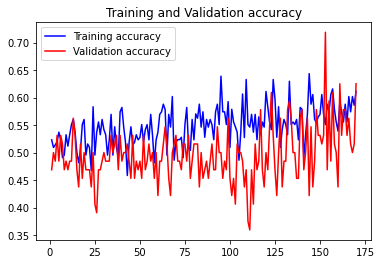

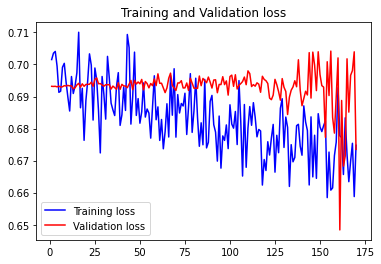

In [28]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

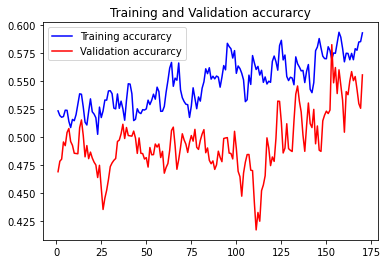

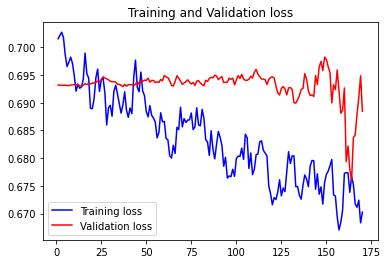

In [29]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [39]:
#Prepare test set

X_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 'adc':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 'adc':
            X_test.append(array)

In [40]:
x = np.array(X_test)
y = np.array(y_test)
y_pred_class = []
y_pred_prob = []
test_datagen = ImageDataGenerator(rescale=1./255)

correct = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    if i == len(x):
        break
    prob = model.predict(batch)
    y_pred_prob.append(prob)
    prediction = int(np.round(prob))
    y_pred_class.append(prediction)
    actual = y[i]
    if prediction == actual:
        correct += 1
        if prediction == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    i += 1

ACCURACY: 0.6774193548387096
SENSITIVITY: 0.26666666666666666
SPECIFICITY: 0.8085106382978723
0.0,0.02127659574468085,0.02127659574468085,0.0425531914893617,0.0425531914893617,0.06382978723404255,0.06382978723404255,0.3191489361702128,0.3191489361702128,0.46808510638297873,0.46808510638297873,0.48936170212765956,0.48936170212765956,0.6595744680851063,0.6595744680851063,0.7446808510638298,0.7446808510638298,0.8085106382978723,0.8085106382978723,0.8297872340425532,0.8297872340425532,0.9148936170212766,0.9148936170212766,1.0
0.0,0.0,0.06666666666666667,0.06666666666666667,0.13333333333333333,0.13333333333333333,0.26666666666666666,0.26666666666666666,0.4666666666666667,0.4666666666666667,0.5333333333333333,0.5333333333333333,0.6,0.6,0.6666666666666666,0.6666666666666666,0.7333333333333333,0.7333333333333333,0.8666666666666667,0.8666666666666667,0.9333333333333333,0.9333333333333333,1.0,1.0
AUC SCORE: 0.5418439716312057
13 49


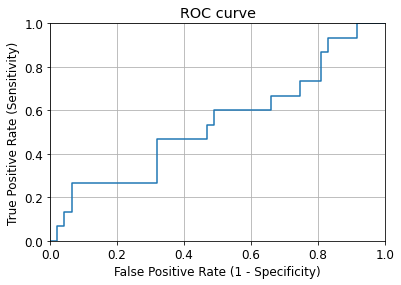

In [41]:
print('ACCURACY:', metrics.accuracy_score(y, y_pred_class))
print('SENSITIVITY:', metrics.recall_score(y, y_pred_class))
print('SPECIFICITY:', true_neg / (true_neg + false_pos))

y_prob = np.array(y_pred_prob).reshape((len(y_pred_prob),))
fpr, tpr, thresholds = metrics.roc_curve(y,y_prob)

print(','.join(str(x) for x in fpr))
print(','.join(str(x) for x in tpr))

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC SCORE:', metrics.roc_auc_score(y,y_prob))

print(false_pos+true_pos, false_neg+true_neg)

In [42]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

evaluate_threshold(0.45)

Sensitivity: 0.6
Specificity: 0.5106382978723405


In [43]:
precision, recall, thresholds = metrics.precision_recall_curve(y,y_prob)
print('PRECISION')
print(','.join(str(x) for x in precision))
print()
print('RECALL')
print(','.join(str(x) for x in recall))

PRECISION
0.25862068965517243,0.24561403508771928,0.25,0.2545454545454545,0.25925925925925924,0.2641509433962264,0.25,0.2549019607843137,0.24,0.22448979591836735,0.22916666666666666,0.23404255319148937,0.2391304347826087,0.2222222222222222,0.22727272727272727,0.23255813953488372,0.23809523809523808,0.24390243902439024,0.225,0.23076923076923078,0.23684210526315788,0.24324324324324326,0.25,0.2571428571428571,0.2647058823529412,0.2727272727272727,0.28125,0.25806451612903225,0.26666666666666666,0.2413793103448276,0.25,0.25925925925925924,0.2692307692307692,0.28,0.2916666666666667,0.30434782608695654,0.3181818181818182,0.2857142857142857,0.25,0.21052631578947367,0.2222222222222222,0.23529411764705882,0.25,0.26666666666666666,0.2857142857142857,0.3076923076923077,0.3333333333333333,0.36363636363636365,0.4,0.4444444444444444,0.5,0.5714285714285714,0.5,0.4,0.5,0.3333333333333333,0.5,0.0,1.0

RECALL
1.0,0.9333333333333333,0.9333333333333333,0.9333333333333333,0.9333333333333333,0.93333333333333

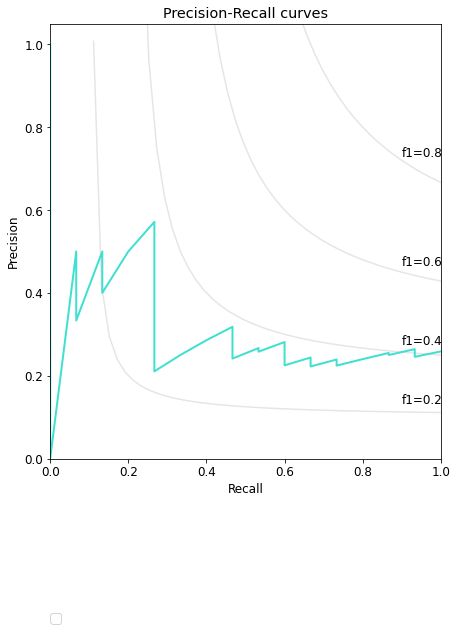

In [44]:
plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

plt.plot(recall, precision, color='turquoise', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

plt.show()